# Amazon Reviews Sentiment Analysis

# Necessary Libraries

In [4]:
!pip install contractions
!pip install pyLDAvis
!pip install tensorflow
!pip install Keras-Preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import pandas as pd
import numpy as np
from numpy import asarray
from numpy import zeros
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from PIL import Image
import re
import unicodedata
import contractions
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import cross_val_score
import multiprocessing
from sklearn.tree import DecisionTreeClassifier

# Sampling Libraries
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# spacy for basic processing, optional, can use nltk as well(lemmatisation etc.)
import spacy

#gensim for LDA
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

#plotting tools
import pyLDAvis
import pyLDAvis.gensim #dont skip this
import matplotlib.pyplot as plt
%matplotlib inline

spacy.cli.download("en_core_web_sm")

# Keras Library
import tensorflow as tf
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from keras import layers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Data Extraction

In [48]:
# from google.colab import files
# uploads = files.upload()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
from google.colab import drive 
drive.mount('/content/drive/')
# https://drive.google.com/file/d/18TnYEH6B441nRi5aB0OCewkWiQLsEktr/view?usp=share_link
# /content/Train.csv

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [7]:
train_path = '/content/drive/MyDrive/Colab Notebooks/Train.csv'
cloud_path = '/content/drive/MyDrive/Colab Notebooks/cloud.png'

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# train_set = pd.read_csv('Train.csv')
train_set = pd.read_csv(train_path)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [52]:
train_set.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,overall,Review
0,5,This a really cool (but time-tested) design. T...
1,5,I liked the first pair so well I bought severa...
2,4,I took them to the range to put them to the te...
3,5,What can you say about a yoga block? These ar...
4,5,After reading many reviews I decided on this l...


# Data Exploration and Visualization

In [53]:
train_set.describe()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,overall
count,222243.000000
mean,4.394771
std,0.985039
min,1.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


In [54]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222243 entries, 0 to 222242
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   overall  222243 non-null  int64 
 1   Review   222243 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
train_set['overall'].value_counts()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5    141169
4     48748
3     17947
2      7650
1      6729
Name: overall, dtype: int64

In [56]:
#Function to Create Wordcloud
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
    
def create_wordcloud(text):
    mask = np.array(Image.open(cloud_path))
    
    mask = np.ndarray((mask.shape[0],mask.shape[1]), np.int32)
    for i in range(len(mask)):
        mask[i] = list(map(transform_format, mask[i]))
    
    wc = WordCloud(background_color='white',
    mask = mask,
    max_words=3000,
    repeat=True)
    wc.generate(str(text))
    wc.to_file('wc.png')
    print('Word Cloud Saved Successfully')
    path='wc.png'
    display(Image.open(path))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


Word Cloud Saved Successfully


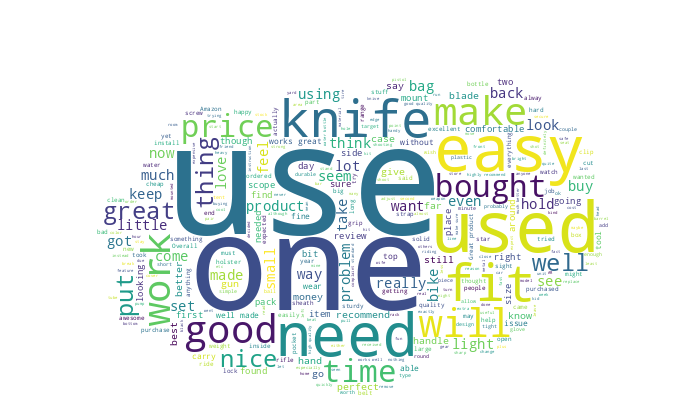

In [57]:
# Create one huge string containing all the reviews
reviews = ' '.join(train_set['Review'])

# Creating the word cloud
create_wordcloud(reviews)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


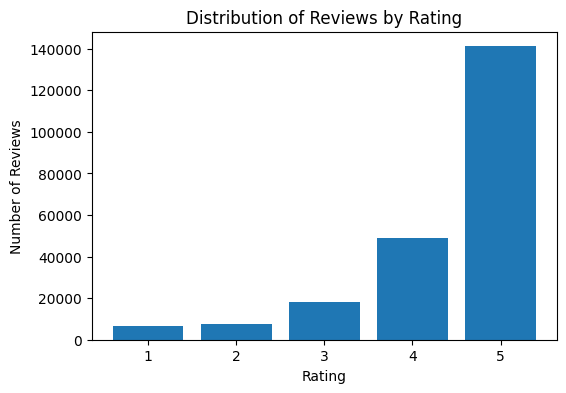

In [58]:
# Calculating the value counts of each rating
ratings= train_set['overall'].value_counts()

# Viewing the ratings value counts using a bar chart
plt.figure(figsize=(6, 4))
plt.bar(ratings.index, ratings.values)
plt.xlabel('Rating')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Reviews by Rating')
plt.show()

Here in the bar chart above, it is shown that the proportions of data is not distributed as reviews with {5} ratings are more than all other reviews cumulatively.

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


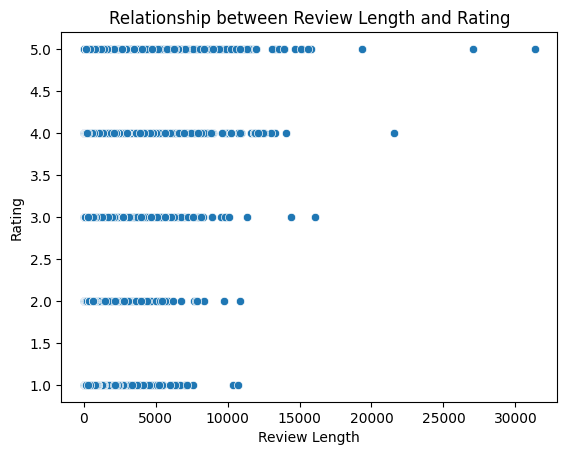

In [59]:
# Adding a column called review_length to the train df
train_set['review_length']=train_set['Review'].apply(len)

# Creating a scatter plot to view the relationship between the rating and the review length
sns.scatterplot(x='review_length', y='overall', data=train_set)
plt.xlabel('Review Length')
plt.ylabel('Rating')
plt.title('Relationship between Review Length and Rating')
plt.show()

 Using the scatter plot above between the ratings and the length of the reviews shows that higher ratings tend to have longer reviews.

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


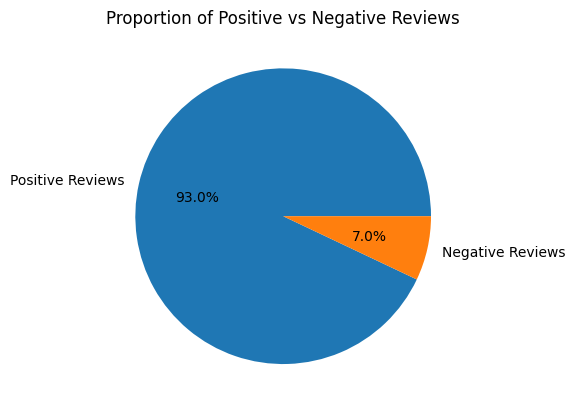

In [60]:
# calculating the proportion of positive vs negative reviews
pos = train_set[train_set['overall'] >= 4]
neg = train_set[train_set['overall'] <= 2]
prop= [len(pos)/len(train_set), len(neg)/len(train_set)]

# pie chart of negative vs positive ratings
labels = ['Positive Reviews', 'Negative Reviews']
plt.pie(prop, labels=labels, autopct='%1.1f%%')
plt.title('Proportion of Positive vs Negative Reviews')
plt.show()

In the pie chart above, {1,2} ratings were considered to be the "Negative Reviews" and {4,5} ratings were considered to be the "Positive Reviews". As mentioned above, reviews with a rating of {5} are more than all other reviews, so this pie chart is quite logical.

In [61]:
train_set = train_set.drop('review_length', axis=1)
train_set.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,overall,Review
0,5,This a really cool (but time-tested) design. T...
1,5,I liked the first pair so well I bought severa...
2,4,I took them to the range to put them to the te...
3,5,What can you say about a yoga block? These ar...
4,5,After reading many reviews I decided on this l...


# Text Processing and Normalization

We will talk about the basic steps of text preprocessing. 
These steps are needed for transferring text from human language to machine-readable format for further processing. 

1. Drop duplicates if any before pre-processing
2. Remove html links
3. Remove accented characters
4. Convert to lower case
5. Remove digits
6. Fix contractions
7. Tokenization

Now depending on the users input the following techniques are applied
1. Stemming with stop words removal
2. lemmatizing with stop words removal
3. Stemming with punctuation removal
4. lemmatizing with punctuation removal
5. Stemming with stop words removal and punctuation removal
6. lemmatizing with stop words removal and punctuation removal


different combination of techniques are listed above in order to be able to evaluate the trade off between different text processing techniques and measure their effectiveness for the current data set.



In [9]:
# Drop duplicates from dataframe if any
train_set.drop_duplicates()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,overall,Review
0,5,This a really cool (but time-tested) design. T...
1,5,I liked the first pair so well I bought severa...
2,4,I took them to the range to put them to the te...
3,5,What can you say about a yoga block? These ar...
4,5,After reading many reviews I decided on this l...
...,...,...
222238,2,"I wear them for running and go to gym, wearing..."
222239,4,Nice and big canister of bear spray. Only obj...
222240,5,I wanted an inexpensive 3wt for ponds and tigh...
222241,5,I saw this type of knife in the hands of rice ...


In [10]:
punc = string.punctuation # list of punctuations to be removed later
stop_words = set(stopwords.words('english')) # list of stop words to be removed later
stop_words -= set(['no', 'not', 'nor', 'but']) # eliminating those words in order not to bias the sentiment later
lemmatizer = WordNetLemmatizer() #lemmatizer
stemmer = PorterStemmer() #stemmer


def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_accented_chars(text):
    #This function removes accented characters from a string.
    text = unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8')
    return text

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
def preprocess(text, technique):
    text = str(text).lower() #lower case
    text = remove_html(text) # remove html if any
    text = re.sub('\[.*?\]', '', text) #removing text enclosed in square brackets 
    text = re.sub('[\n\t\r]', '', text)# removing new lines, tabs, and carriages
    text = re.sub('\w*\d\w*', '', text) #removing digits
    text = remove_accented_chars(text) #removing accented characters
    text = contractions.fix(text) #fixing contractions
    tokens = nltk.word_tokenize(text) #tokenization

    # apply text processing technique
    if technique == 'stem_punc':
        processed = [stemmer.stem(token) for token in tokens if token not in punc]
    elif technique == 'stem_stop':
        processed = [stemmer.stem(token) for token in tokens if token not in stop_words]
    elif technique == 'lemma_punc':
        processed = [lemmatizer.lemmatize(token) for token in tokens if token not in punc]
    elif technique == 'lemma_stop':
        processed = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    elif technique == 'stem_punc_stop':
        processed = [stemmer.stem(token) for token in tokens if token not in punc and token not in stop_words]
    elif technique == 'lemma_punc_stop': 
        processed = [lemmatizer.lemmatize(token) for token in tokens if token not in punc and token not in stop_words]
    
    return  ' '.join(processed)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:4: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \[
<>:6: DeprecationWarning: invalid escape sequence \w
<ipython-input-11-c13aacf11269>:4: DeprecationWarning: invalid escape sequence \[
  text = re.sub('\[.*?\]', '', text) #removing text enclosed in square brackets
<ipython-input-11-c13aacf11269>:6: DeprecationWarning: invalid escape sequence \w
  text = re.sub('\w*\d\w*', '', text) #removing digits


This method preprocess can be used to preprocess the reviews column.
The user can choose from the following types of preprocessing combinations:

- 1) Stemming + Punctuation Removal: 'stem_punc'
- 2) Stemming + Stop Words Removal: 'stem_stop'
- 3) Lemmatization + Punctuation Removal: 'lemma_punc'
- 4) Lemmatization + Stop Words Removal: 'lemma_stop'
- 5) Stemming + Punctuation Removal + Stop Words Removal : 'stem_punc_stop'
- 6) Lemmatization + Punctuation Removal + Stop Words Removal : 'lemma_punc_stop'

using those options, we can later compare which techniques of preprocessing are benefical to our data set and which are. We can later explain the trade-off of using each and justify their effectiveness for the current data set.  

examples of using all 6 options:

In [12]:
first_review = train_set['Review'][0]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [67]:
stem_punc = preprocess(first_review, 'stem_punc')
stem_punc

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'thi a realli cool but time-test design the carbon steel blade get realli sharp but doe requir mainten from time to time i oil the lock screw-top and blade after that it open easili i have been use mine for a coupl of month now and am not disappoint it is a solid knife and at an afford price nice knife'

In [68]:
stem_stop = preprocess(first_review, 'stem_stop')
stem_stop

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'realli cool ( but time-test ) design . carbon steel blade get realli sharp but requir mainten time time . oil lock screw-top blade ; open easili . use mine coupl month not disappoint . solid knife afford price . nice knife !'

In [69]:
lemma_punc = preprocess(first_review, 'lemma_punc')
lemma_punc

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'this a really cool but time-tested design the carbon steel blade get really sharp but doe require maintenance from time to time i oiled the locking screw-top and blade after that it open easily i have been using mine for a couple of month now and am not disappointed it is a solid knife and at an affordable price nice knife'

In [70]:
lemma_stop = preprocess(first_review, 'lemma_stop')
lemma_stop

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'really cool ( but time-tested ) design . carbon steel blade get really sharp but require maintenance time time . oiled locking screw-top blade ; open easily . using mine couple month not disappointed . solid knife affordable price . nice knife !'

In [71]:
stem_punc_stop = preprocess(first_review, 'stem_punc_stop')
stem_punc_stop

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'realli cool but time-test design carbon steel blade get realli sharp but requir mainten time time oil lock screw-top blade open easili use mine coupl month not disappoint solid knife afford price nice knife'

In [72]:
lemma_punc_stop = preprocess(first_review, 'lemma_punc_stop')
lemma_punc_stop

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


'really cool but time-tested design carbon steel blade get really sharp but require maintenance time time oiled locking screw-top blade open easily using mine couple month not disappointed solid knife affordable price nice knife'

In [14]:
# Apply pre-processing steps using "lemma_punc_stop" 
train_set['cleanedReviews'] = train_set['Review'].apply(lambda x: preprocess(x, 'lemma_punc_stop'))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [74]:
train_set.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,overall,Review,cleanedReviews
0,5,This a really cool (but time-tested) design. T...,really cool but time-tested design carbon stee...
1,5,I liked the first pair so well I bought severa...,liked first pair well bought several found usu...
2,4,I took them to the range to put them to the te...,took range put test adjust volume hear people ...
3,5,What can you say about a yoga block? These ar...,say yoga block solid sturdy not name-brand fea...
4,5,After reading many reviews I decided on this l...,reading many review decided light satisfied da...


# Vector space Model and feature representation

In [75]:
# Experiment with different vectorizers and n-gram features
vectorizers = [CountVectorizer, TfidfVectorizer]
ngram_ranges = [(1,1), (1,2), (1,3)]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Model training, selection and hyperparameter tuning and evaluation

In [15]:
# setting the X and y for the training dataset
X = train_set['cleanedReviews']
y = train_set['overall']

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [77]:
def eval_model(model,X,y):
    # predict
    y_p= model.predict(X)
    # Evaluation metrics
    print(classification_report(y, y_p))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [78]:
def hyperparameters(model, param_grid, X, y, cv=5, scoring='accuracy'):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring=scoring)
    grid_search.fit(X, y)
    print("Best hyperparameters: ", grid_search.best_params_)
    print("Best " + scoring + ": {:.2f}".format(grid_search.best_score_))
    print("\n")
    
    return grid_search

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [79]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the test set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## 1) Multinomial NB Model 

In [80]:
for vectorizer in vectorizers:
    for ngram_range in ngram_ranges:
        print("\n")
        print("Vectorizer: ",vectorizer.__name__)
        print("N-grams: ",ngram_range)
        print("\n")
        # Initialize vectorizer
        vec = vectorizer(ngram_range=ngram_range)
        
        # Fit vectorizer and transform X data
        X_train_v = vec.fit_transform(X_train)
        X_val_v = vec.transform(X_val)
        X_test_v = vec.transform(X_test)
        
        # Train machine learning model
        clf = MultinomialNB()
        clf.fit(X_train_v, y_train)
        
        # Evaluate the model on the validation set
        print("Metrics of Validation set:")
        eval_model(clf,X_val_v,y_val)
        
        # Evaluate the model on the testing set
        print("Metrics of Testing set:")
        eval_model(clf,X_test_v,y_test)
        
        print ("=================================")
        

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)




Vectorizer:  CountVectorizer
N-grams:  (1, 1)


Metrics of Validation set:
              precision    recall  f1-score   support

           1       0.56      0.29      0.38       973
           2       0.24      0.02      0.04      1133
           3       0.39      0.19      0.26      2635
           4       0.42      0.39      0.40      7235
           5       0.76      0.89      0.82     21360

    accuracy                           0.68     33336
   macro avg       0.47      0.35      0.38     33336
weighted avg       0.64      0.68      0.65     33336

Metrics of Testing set:
              precision    recall  f1-score   support

           1       0.62      0.35      0.44       951
           2       0.28      0.02      0.04      1133
           3       0.40      0.18      0.25      2691
           4       0.42      0.38      0.40      7380
           5       0.76      0.89      0.82     21182

    accuracy                           0.67     33337
   macro avg       0.49      0

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           1       1.00      0.01      0.01       973
           2       0.00      0.00      0.00      1133
           3       0.72      0.00      0.01      2635
           4       0.43      0.07      0.12      7235
           5       0.66      0.99      0.79     21360

    accuracy                           0.65     33336
   macro avg       0.56      0.22      0.19     33336
weighted avg       0.60      0.65      0.54     33336

Metrics of Testing set:
              precision    recall  f1-score   support

           1       0.67      0.00      0.01       951
           2       1.00      0.00      0.00      1133
           3       0.61      0.01      0.01      2691
           4       0.45      0.07      0.12      7380
           5       0.66      1.00      0.79     21182

    accuracy                           0.65     33337
   macro avg       0.68      0.22      0.19     33337
weighted avg       0.62      0.65      0.53     33337

KeyboardInterrupt: ignored

## 2) Bernoulli NB Model

In [ ]:
for vectorizer in vectorizers:
    for ngram_range in ngram_ranges:
        print("\n")
        print("Vectorizer: ",vectorizer.__name__)
        print("N-grams: ",ngram_range)
        print("\n")
        # Initialize vectorizer
        vec = vectorizer(ngram_range=ngram_range)
        
        # Fit vectorizer and transform X data
        X_train_v = vec.fit_transform(X_train)
        X_val_v = vec.transform(X_val)
        X_test_v = vec.transform(X_test)
        
        # Train machine learning model
        BNB = BernoulliNB()
        BNB.fit(X_train_v, y_train)
        
        # Evaluate the model on the validation set
        print("Metrics of Validation set:")
        eval_model(BNB,X_val_v,y_val)
        
        # Evaluate the model on the testing set
        print("Metrics of Testing set:")
        eval_model(BNB,X_test_v,y_test)
        
        print ("=================================")
        

## 3) Random Forest Classifier

Using the CountVectorizer with unigram to transform the data and apply random forest classifier with hyperparameter tuning using GridSearchCV. Then fitting the data using the best hyperparameters, and evaluating the model on the validation set and testing set.

In [ ]:
count_1_vec = CountVectorizer(ngram_range=(1,1))
X_train_c1v = count_1_vec.fit_transform(X_train)
X_val_c1v = count_1_vec.transform(X_val)
X_test_c1v = count_1_vec.transform(X_test)

In [ ]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30]
}

In [ ]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=multiprocessing.cpu_count())

In [ ]:
grid_search.fit(X_train_c1v, y_train)

In [ ]:
# Print best hyperparameters for random forest classifier
print("Best hyperparameters: ", grid_search.best_params_)
print("Best Accuracy" + ": {:.2f}".format(grid_search.best_score_))

In [ ]:
# Evaluate the model on the validation set
print("Metrics of Validation set:")
eval_model(grid_search,X_val_c1v,y_val)

In [ ]:
# Evaluate the model on the testing set
print("Metrics of Testing set:")
eval_model(grid_search,X_test_c1v,y_test)

## 4) Decision Trees

In [ ]:
dt = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4],
}

In [ ]:
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=multiprocessing.cpu_count())

In [ ]:
grid_search.fit(X_train_c1v, y_train)

In [ ]:
# Print best hyperparameters for Decision Trees
print("Best hyperparameters: ", grid_search.best_params_)
print("Best Accuracy" + ": {:.2f}".format(grid_search.best_score_))

In [ ]:
# Evaluate the model on the validation set
print("Metrics of Validation set:")
eval_model(grid_search,X_val_c1v,y_val)

In [ ]:
# Evaluate the model on the testing set
print("Metrics of Testing set:")
eval_model(grid_search,X_test_c1v,y_test)

## Sampling

### Undersampling using Multinomial NB

In [ ]:
y_train.value_counts()

Here we can see that the value counts of classes are not even close to each other that is why the next step will be sampling in order to check if we balanced the classes using under sampling will the results change? Let's see.

In [ ]:
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy="not minority", random_state=42)
# fit and apply the transform
X_over, y_over = undersample.fit_resample(X_train_c1v, y_train)
# summarize class distribution
print(Counter(y_over))

In [ ]:
clf = MultinomialNB()

# number of unique classes (used later in "class_prior parameter")
n_classes = np.unique(y_train)

# tuning the multinomial NB using the gridsearch
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, ],
          'fit_prior': [True, False],
          'class_prior': [None, [0.1,]* len(n_classes), ]
         }

grid_search = hyperparameters(clf, params, X_over, y_over)

In [ ]:
 # Evaluate the model on the validation set
print("Metrics of Validation set:")
eval_model(grid_search,X_val_c1v,y_val)
        
# Evaluate the model on the testing set
print("Metrics of Testing set:")
eval_model(grid_search,X_test_c1v,y_test)

### Oversampling using Mulitnomial NB

In [ ]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy="minority", random_state=42)
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train_c1v, y_train)
# summarize class distribution
print(Counter(y_over))

Here we did over sampling however because the original dataset is highly imbalanced, so even after using applying oversampling, the distribution classes may not be perfectly balanced.

In [ ]:
clf = MultinomialNB()

# number of unique classes (used later in "class_prior parameter")
n_classes = np.unique(y_train)

# tuning the multinomial NB using the gridsearch
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, ],
          'fit_prior': [True, False],
          'class_prior': [None, [0.1,]* len(n_classes), ]
         }

grid_search = hyperparameters(clf, params, X_over, y_over)

In [ ]:
 # Evaluate the model on the validation set
print("Metrics of Validation set:")
eval_model(grid_search,X_val_c1v,y_val)
        
# Evaluate the model on the testing set
print("Metrics of Testing set:")
eval_model(grid_search,X_test_c1v,y_test)

### Undersampling using Bernoulli NB

In [ ]:
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy="not minority", random_state=42)
# fit and apply the transform
X_over, y_over = undersample.fit_resample(X_train_c1v, y_train)
# summarize class distribution
print(Counter(y_over))

In [ ]:
# number of unique classes (used later in "class_prior parameter")
n_classes = np.unique(y_train)

# tuning the Bernoulli NB using the gridsearch
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
          'fit_prior': [True, False],
          'class_prior': [None, [0.1,]* len(n_classes), ],
          'binarize': [None, 0.0, 8.5, 10.0]
         }

BNB = BernoulliNB()

grid_search = hyperparameters(BNB, params, X_over, y_over)

In [ ]:
 # Evaluate the model on the validation set
print("Metrics of Validation set:")
eval_model(grid_search,X_val_c1v,y_val)
        
# Evaluate the model on the testing set
print("Metrics of Testing set:")
eval_model(grid_search,X_test_c1v,y_test)

### Oversampling using Bernoulli NB

In [ ]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy="minority", random_state=42)
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train_c1v, y_train)
# summarize class distribution
print(Counter(y_over))

In [ ]:
# number of unique classes (used later in "class_prior parameter")
n_classes = np.unique(y_train)

# tuning the Bernoulli NB using the gridsearch
params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
          'fit_prior': [True, False],
          'class_prior': [None, [0.1,]* len(n_classes), ],
          'binarize': [None, 0.0, 8.5, 10.0]
         }

BNB = BernoulliNB()

grid_search = hyperparameters(BNB, params, X_over, y_over)

In [ ]:
# Evaluate the model on the validation set
print("Metrics of Validation set:")
eval_model(grid_search,X_val_c1v,y_val)
        
# Evaluate the model on the testing set
print("Metrics of Testing set:")
eval_model(grid_search,X_test_c1v,y_test)

### Undersampling using Random Forest

In [ ]:
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy="not minority", random_state=42)
# fit and apply the transform
X_over, y_over = undersample.fit_resample(X_train_c1v, y_train)
# summarize class distribution
print(Counter(y_over))

In [ ]:
rf = RandomForestClassifier(random_state=42)

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30]
}

grid_search = hyperparameters(rf, params, X_over, y_over)

In [ ]:
# Evaluate the model on the validation set
print("Metrics of Validation set:")
eval_model(grid_search,X_val_c1v,y_val)
        
# Evaluate the model on the testing set
print("Metrics of Testing set:")
eval_model(grid_search,X_test_c1v,y_test)

### Oversampling using Random Forest

In [ ]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy="minority", random_state=42)
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train_c1v, y_train)
# summarize class distribution
print(Counter(y_over))

In [ ]:
rf = RandomForestClassifier(random_state=42)

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30]
}

grid_search = hyperparameters(rf, params, X_over, y_over)

In [ ]:
# Evaluate the model on the validation set
print("Metrics of Validation set:")
eval_model(grid_search,X_val_c1v,y_val)
        
# Evaluate the model on the testing set
print("Metrics of Testing set:")
eval_model(grid_search,X_test_c1v,y_test)

### Undersampling using Decision Trees

In [ ]:
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy="not minority", random_state=42)
# fit and apply the transform
X_over, y_over = undersample.fit_resample(X_train_c1v, y_train)
# summarize class distribution
print(Counter(y_over))

In [ ]:
dt = DecisionTreeClassifier()
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4],
}
grid_search = hyperparameters(dt, params, X_over, y_over)

In [ ]:
# Evaluate the model on the validation set
print("Metrics of Validation set:")
eval_model(grid_search,X_val_c1v,y_val)
        
# Evaluate the model on the testing set
print("Metrics of Testing set:")
eval_model(grid_search,X_test_c1v,y_test)

### Oversampling using Decision Trees

In [ ]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy="minority", random_state=42)
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train_c1v, y_train)
# summarize class distribution
print(Counter(y_over))

In [ ]:
dt = DecisionTreeClassifier()
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 3, 4, 5],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4],
}
grid_search = hyperparameters(dt, params, X_over, y_over)

In [ ]:
# Evaluate the model on the validation set
print("Metrics of Validation set:")
eval_model(grid_search,X_val_c1v,y_val)
        
# Evaluate the model on the testing set
print("Metrics of Testing set:")
eval_model(grid_search,X_test_c1v,y_test)

# Modelling text as a Sequence

## Sequential model with Word Embeddings

## Embedding Layer

Till now, we have used bag of words concept which has the disadvantage of losing the semantic information present in word ordering. Word Embeddings are best way to represent text as numbers in a dense way. 

Word embedding helps capture the semantic or syntactic context of the reviews and can help us to understand how similar/dissimilar it is to other sentences in the reviews document, which would somehow yield better results during prediction.

There are different types of embedding techniques like below..
1. TF-IDF — Term Frequency-Inverse Document Frequency
   Statistical method to capture the relevance of words w.r.t the corpus of text. It does not capture semantic word associations.
   Better for information retrieval and keyword extraction in documents.
2. Word2Vec — Capturing Semantic Information
   Neural network-based CBOW and Skip-gram architectures, better at capturing semantic information.
   Useful in semantic analysis task.
3. GloVe — Global Vectors for Word Representation 
   Matrix factorization based on global word-word co-occurrence. It solves the local context limitations of Word2Vec.
   etter at word analogy and named-entity recognition tasks. Comparable results with Word2Vec in some semantic      analysis tasks while better in others.
4. BERT — Bidirectional Encoder Representations from Transformers
   Transformer-based attention mechanism to capture high-quality contextual information.
   Language translation, question-answering system. Deployed in Google Search engine to understand search queries.
   
Reference: https://www.kdnuggets.com/2021/11/guide-word-embedding-techniques-nlp.html

Let's experiment sequence models with embedding layer and see how the model perform..


In [81]:
y.value_counts()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5    141169
4     48748
3     17947
2      7650
1      6729
Name: overall, dtype: int64

In [84]:
# Splitting dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Embedding layer expects the words to be in numeric form 
# Using Tokenizer function from keras.preprocessing.text library
# Method fit_on_text trains the tokenizer 
# Method texts_to_sequences converts sentences to their numeric form
word_tokenizer = Tokenizer(num_words=5000)
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [85]:
import io
import json
# Saving
tokenizer_json = word_tokenizer.to_json()
with io.open('b3_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
# Adding 1 to store dimensions for words for which no pretrained word embeddings exist
vocab_length = len(word_tokenizer.word_index) + 1
vocab_length
# Padding all reviews to fixed length 1500
# maxlen = 1500
maxlen = max([len(listElem.split()) for listElem in X])
print(maxlen)
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2889


## Glove - pretrained embedding model

In [87]:
# Download Glove - pretrained embedding model for usage
!wget nlp.stanford.edu/data/glove.6B.zip

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


--2023-04-03 18:20:24--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-04-03 18:20:24--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-03 18:20:24--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

gl

In [88]:
!unzip glove*.zip

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Create Embedding Matrix

In [89]:
# Load GloVe word embeddings and create an Embeddings Dictionary
embeddings_dictionary = dict()
glove_file = open('glove.6B.300d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
# Create Embedding Matrix having 300 columns 
# Containing 300-dimensional GloVe word embeddings for all words in our corpus.
embedding_matrix = zeros((vocab_length, 300))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Model training with simple sequencial Neural network

In [ ]:
# Neural Network architecture

snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 300, weights=[embedding_matrix], input_length=maxlen , trainable=False)
snn_model.add(embedding_layer)
snn_model.add(Flatten())
snn_model.add(Dense(5, activation='softmax'))

In [ ]:
# Model compiling
snn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(snn_model.summary())

In [ ]:
# Model training

snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=3, verbose=1, validation_split=0.2)

In [ ]:
# Predictions on the Test Set
score = snn_model.evaluate(X_test, y_test, verbose=1)

In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:

# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Model training with simple sequencial CNN

In [ ]:
from keras.layers import Conv1D

In [ ]:
# Neural Network architecture

cnn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(5, activation='softmax'))

In [ ]:
# Model compiling

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(cnn_model.summary())

In [ ]:
# Model training

cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

In [ ]:
# Predictions on the Test Set

score = cnn_model.evaluate(X_test, y_test, verbose=1)

In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

## Model training with simple sequencial RNN (LSTM)

In [ ]:
from keras.layers import LSTM

In [ ]:
# Neural Network architecture

lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(5, activation='softmax'))

In [ ]:
# Model compiling

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(lstm_model.summary())

In [ ]:
# Model Training

lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

In [ ]:
# Predictions on the Test Set

score = lstm_model.evaluate(X_test, y_test, verbose=1)

In [ ]:
# Model Performance

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

In [ ]:
# Model Performance Charts

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Topic Modelling

Topic modeling can be described as a method of finding a topic from the collection of documents that best represents the information in those documents.

In [16]:
# tokenize using gensims simple_preprocess
def sent_to_words(sentences, deacc=True):  # deacc=True removes punctuations
    for sentence in sentences:
        yield(simple_preprocess(str(sentence)))

# functions for removing stopwords and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts,allowed_postags=['NOUN','ADJ','VERB','ADV']):
    """https://spacy.io/api/annotation"""
    texts_out=[]
    for sent in texts:
        doc=nlp(' '.join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# convert to list
data=X.tolist()
data_words=list(sent_to_words(data))
stop_words= stopwords.words('english') + list(string.punctuation)

# remove stop words
data_words_npstops= remove_stopwords(data_words)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# initialize spacy 
nlp=spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# lemmatization keeping only noun, adj, vb, adv
data_lemmatized=lemmatization(data_words_npstops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# create dictionary and corpus
id2word=corpora.Dictionary(data_lemmatized)
corpus=[id2word.doc2bow(text) for text in data_lemmatized]

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


** Building the Topic Model **

LDA - Latent Dirichlet allocation (LDA), a generative probabilistic model for collections of discrete data such as text corpora. LDA is a three-level hierarchical Bayesian model, in which each item of a collection is modeled as a finite mixture over an underlying set of topics. Each topic is, in turn, modeled as an infinite mixture over an underlying set of topic probabilities. In the context of text modeling, the topic probabilities provide an explicit representation of a document

In [ ]:
# Build LDA model
lda_model= gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=10,random_state=100,\
                                          update_every=1,chunksize=100,passes=10,alpha='auto',per_word_topics=True)

In [ ]:
# print keywords 
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

In [ ]:
# coherence score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

## Hyperparameter Tuning - Number of Topics and Alpha

In [ ]:
# compute coherence value at various values of alpha and num_topics
def compute_coherence_values(dictionary, corpus, texts, num_topics_range,alpha_range):
    coherence_values=[]
    model_list=[]
    for alpha in alpha_range:
        for num_topics in num_topics_range:
            lda_model= gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, alpha=alpha,num_topics=num_topics,\
                                                      per_word_topics=True)
            model_list.append(lda_model)
            coherencemodel=CoherenceModel(model=lda_model,texts=texts,dictionary=dictionary,coherence='c_v')
            coherence_values.append((alpha,num_topics,coherencemodel.get_coherence()))
    return model_list,coherence_values

In [ ]:
# build models accross a range of num_topics and alpha
num_topics_range= [2,6,10,15,20]
alpha_range=[0.01,0.1,1]
model_list, coherence_values= compute_coherence_values(dictionary=id2word,corpus=corpus,texts=data_lemmatized,\
                                                       num_topics_range=num_topics_range,alpha_range=alpha_range)


In [ ]:
coherence_df = pd.DataFrame(coherence_values, columns=['alpha', 'num_topics', 'coherence_value'])
coherence_df

In [ ]:
# plot
def plot_coherence(coherence_df,alpha_range,num_topics_range):
    plt.figure(figsize=(16,6))
    
    for i,val in enumerate(alpha_range):
        #subolot 1/3/i
        plt.subplot(1,3,i+1)
        alpha_subset=coherence_df[coherence_df['alpha']==val]
        plt.plot(alpha_subset['num_topics'],alpha_subset['coherence_value'])
        plt.xlabel('num_topics')
        plt.ylabel('Coherence Value')
        plt.title('alpha={0}'.format(val))
        plt.ylim([0.30,1])
        plt.legend('coherence value', loc='upper left')
        plt.xticks(num_topics_range)
plot_coherence(coherence_df,alpha_range,num_topics_range)

## Testing Dataset:

In [ ]:
test = pd.read_csv('/content/sample_data/test.csv')

In [ ]:
test.info()

In [ ]:
test.head()

In [ ]:
count_1_vec = CountVectorizer(ngram_range=(1,1))

In [ ]:
test.drop_duplicates()

In [ ]:
test['cleanedReviews']= test['Review'].apply(lambda x: preprocess(x, 'lemma_punc_stop'))


In [ ]:
X_train =  count_1_vec.fit_transform(train_set['cleanedReviews'])
X_test = count_1_vec.transform(test['cleanedReviews'])

In [ ]:
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy="minority", random_state=42)
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train, y)
# summarize class distribution
print(Counter(y_over))

In [ ]:
rf = RandomForestClassifier(max_depth= 30, n_estimators = 100, random_state=42)
rf.fit(X_over, y_over)

In [ ]:
 y= rf.predict(X_test)

In [ ]:
sample=pd.read_csv('/content/sample_data/sample_submission.csv')

In [ ]:
sample.info()

In [ ]:
sample.describe()

In [ ]:
# This will be your baseline classification (compare to output of majority class)
print("Test set score:{:.2f}".format(np.mean(y==sample.overall)))

In [ ]:
sample['overall'] = y

In [ ]:
sample.to_csv('Mysubmission.csv', index=False)

In [ ]:
clf = MultinomialNB(alpha = 1.0, fit_prior = True)
clf.fit(X_over, y_over)

In [ ]:
 y= rf.predict(X_test)